# K2 C13 Lightcurve of V827 Tau

In this notebook we retrieve K2 lightcurves for sources that appear in both the Grankin et al. sample and K2 Campaign 13.

|Grankin Name| EPIC ID | In C13|
|-- | -- | --|
|LkCa 16 | 247864498 | Y|
|TAP 35 | 210662824 | Y|
|TAP 41 | 210670948 | Y|
|TAP 45 | 247034775 | Y |
|V827 Tau | [210698281](https://archive.stsci.edu/missions/hlsp/k2sff/c13/210600000/98281/hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_allfiles.tar.gz) | Y|
|LkCa 14 | 247987905 | N|
|V836 Tau | 247942233 | N|


Sub-tasks:
- Retrieve Vanderburg et al. lightcurves
- Make plots
- Run Everest?

## Retrieve Vanderburg et al. K2SFF K2 data

Navigate to the [K2SFF High Level Science Products portal](https://archive.stsci.edu/k2/hlsp/k2sff/search.php) at MAST.  From there you can manually download the tarballs containing the processed data and some metadata and plots.

In [1]:
! ls ../data/K2/c13/210600000/98281/

hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_correction.png
hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_image.png
hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_llc-default-aper.txt
hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_llc.fits
hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_llc.png
hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_medians.png
hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_skypos.png


In [2]:
#! open ../data/K2/c13/210600000/98281/

## Read in and clean the data

In [3]:
#! head /Users/obsidian/Desktop/defaults.py

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
#! head ../data/K2/c13/210600000/98281/hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_llc-default-aper.txt

In [6]:
fn = '../data/K2/c13/210600000/98281/hlsp_k2sff_k2_lightcurve_210698281-c13_kepler_v1_llc-default-aper.txt'
df_vdb = pd.read_csv(fn, usecols=[0,1])
df_vdb.columns = [c.strip() for c in df_vdb.columns.values.tolist()] # Clean whitespace
df_vdb.head()

,BJD - 2454833,Corrected Flux
0,2988.521063,0.932209
1,2988.541495,0.935033
2,2988.561927,0.940807
3,2988.582359,0.947226
4,2988.602791,0.951171


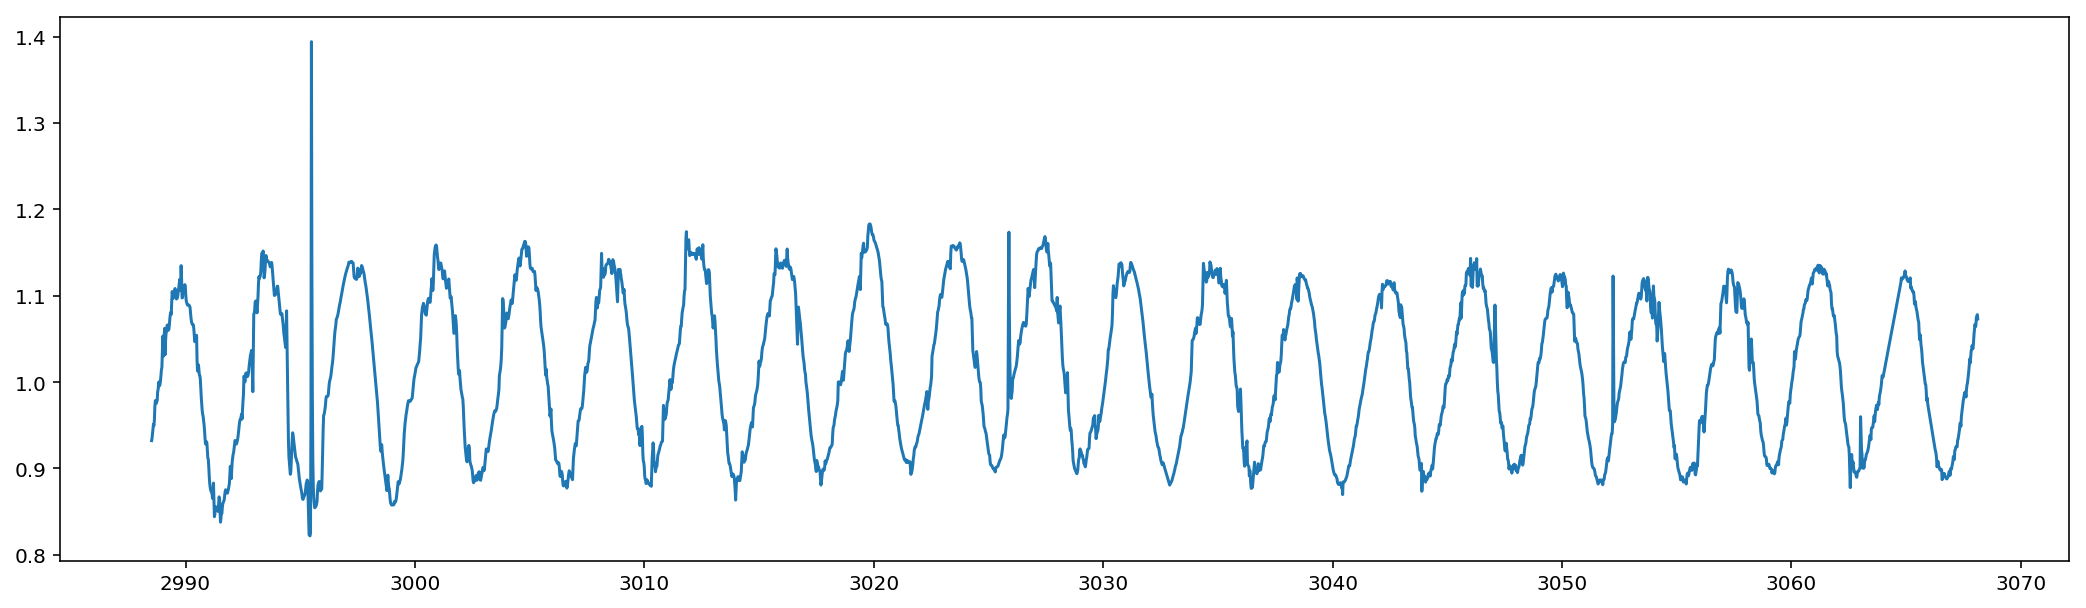

In [7]:
plt.figure(figsize=(18, 5))
plt.plot(df_vdb['BJD - 2454833'], df_vdb['Corrected Flux']);

Looks like a flare went off?  Large sinusoidal variations indicative of starspot modulation.

## Sinusoidal modeling

We'll start by analyzing the information available from all sources *other* than K2.

In [8]:
import sys
import os

In [9]:
sys.path.append(os.path.abspath("../code/"))

In [10]:
import astroML

In [11]:
from xphotometryx import master_photometry

In [12]:
from xphotometryx import run_periodograms
from xphotometryx import plot_LC_and_periodograms
from xphotometryx import top_N_periods

### Ground-based photometry analysis

The master photometry dataframe contains all non-K2 photometry for all sources.  Let's just focus on V827 right now.

In [13]:
master_df = master_photometry()
#master_df.object.unique()

In [14]:
V827_df = master_df[master_df.object == 'V827 Tau'].reset_index(drop=True)
V827_df.head()

,JD_like,year,month,day,season,Vmag,Verr,Bmag,Berr,Rmag,Rerr,Umag,Uerr,source,date_type,object
0,2.448136e+06,1990,9,1.9914,6,12.378,0.01,13.794,0.01,11.035,0.01,NaN,NaN,Grankin et al. 2008,HJD,V827 Tau
1,2.448139e+06,1990,9,4.9898,6,12.415,0.01,13.817,0.01,11.050,0.01,NaN,NaN,Grankin et al. 2008,HJD,V827 Tau
2,2.448140e+06,1990,9,5.9887,6,12.384,0.01,13.726,0.01,11.017,0.01,NaN,NaN,Grankin et al. 2008,HJD,V827 Tau
3,2.448141e+06,1990,9,6.9791,6,12.250,0.01,13.610,0.01,10.943,0.01,NaN,NaN,Grankin et al. 2008,HJD,V827 Tau
4,2.448142e+06,1990,9,7.9840,6,12.284,0.01,13.724,0.01,10.959,0.01,NaN,NaN,Grankin et al. 2008,HJD,V827 Tau


In [15]:
V827_df['Vflux'] = 10**(V827_df.Vmag/-2.5)
V827_df['Vflux'] = V827_df.Vflux/V827_df.Vflux.max()

In [16]:
#V827_df.plot('JD_like', 'Vflux', kind='scatter', ylim=(0, 1.1))
#plt.axhline(1.0, color='k', linestyle='dashed')

In [17]:
x = V827_df.JD_like.values
y = V827_df.Vflux.values
yerr = y*0.02

light_curve = pd.DataFrame({"time":x, "flux":y, "err":yerr})

In [22]:
light_curve = light_curve[light_curve.flux.notnull()].reset_index(drop=True)

/Users/obsidian/anaconda3/lib/python3.6/site-packages/astroML/time_series/periodogram.py:176: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  M, chi2[i], rank, s = np.linalg.lstsq(X, y)


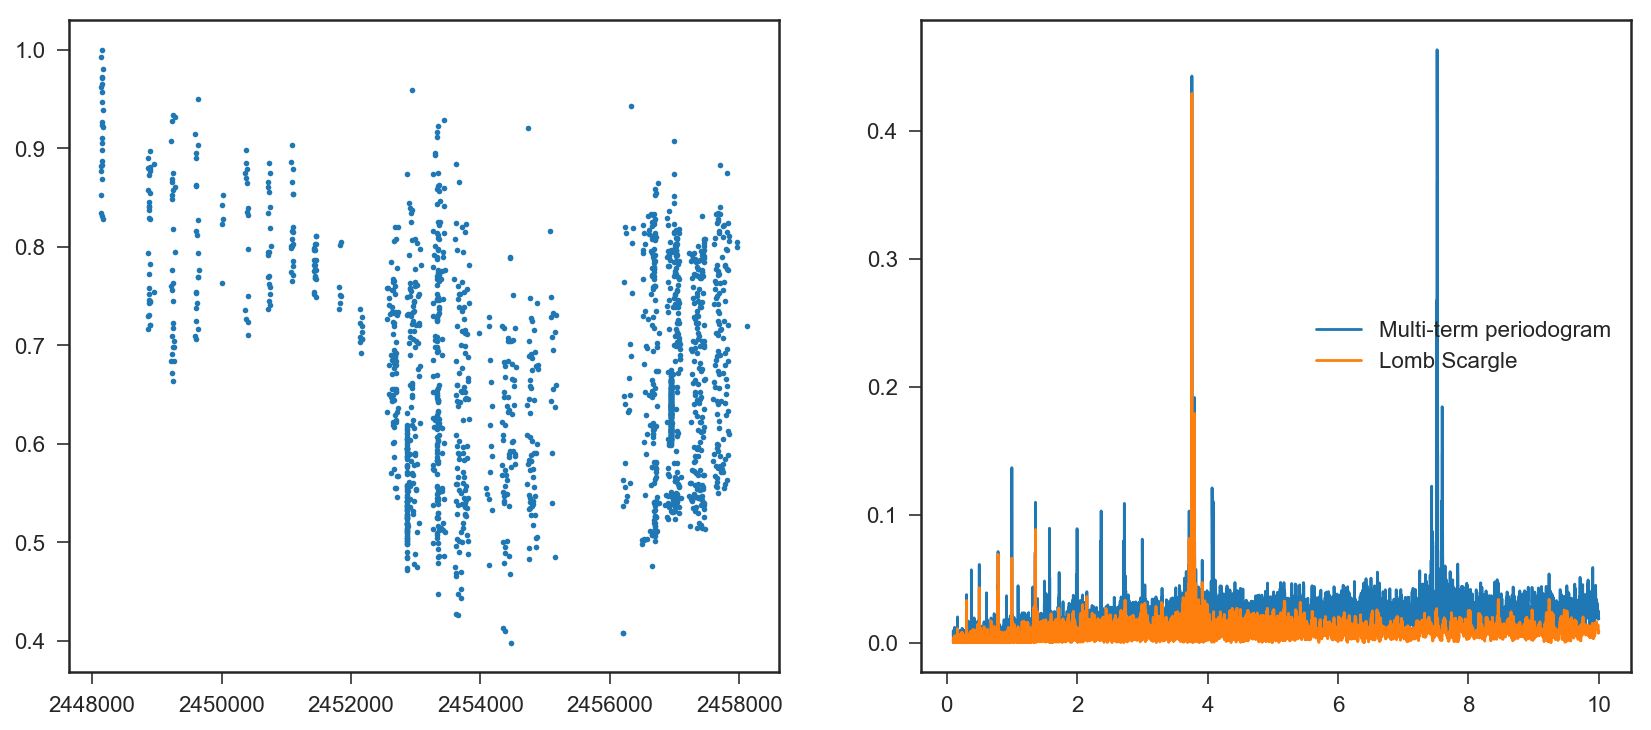

In [23]:
periods, P_M, P_LS = run_periodograms(light_curve)
plot_LC_and_periodograms(light_curve, periods, P_M, P_LS)

In [24]:
p_days_LS, X_sq_M = top_N_periods(periods, P_LS)
p_days_LS

array([3.76039604, 3.75643564, 3.7990099 , 3.76435644, 3.7960396 ])

In [25]:
p_days_M, X_sq_LS = top_N_periods(periods, P_M)
p_days_M

array([7.52079208, 3.76039604, 7.51287129, 3.75643564, 3.7990099 ])

It looks like $P\sim3.756$ days is the period.

### K2 Analysis

Data from only K2 Campaign 13

In [80]:
x = df_vdb['BJD - 2454833'].values
y = df_vdb['Corrected Flux'].values
yerr = y*0.01

light_curve = pd.DataFrame({"time":x, "flux":y, "err":yerr})

/Users/obsidian/anaconda3/lib/python3.6/site-packages/astroML/time_series/periodogram.py:176: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  M, chi2[i], rank, s = np.linalg.lstsq(X, y)


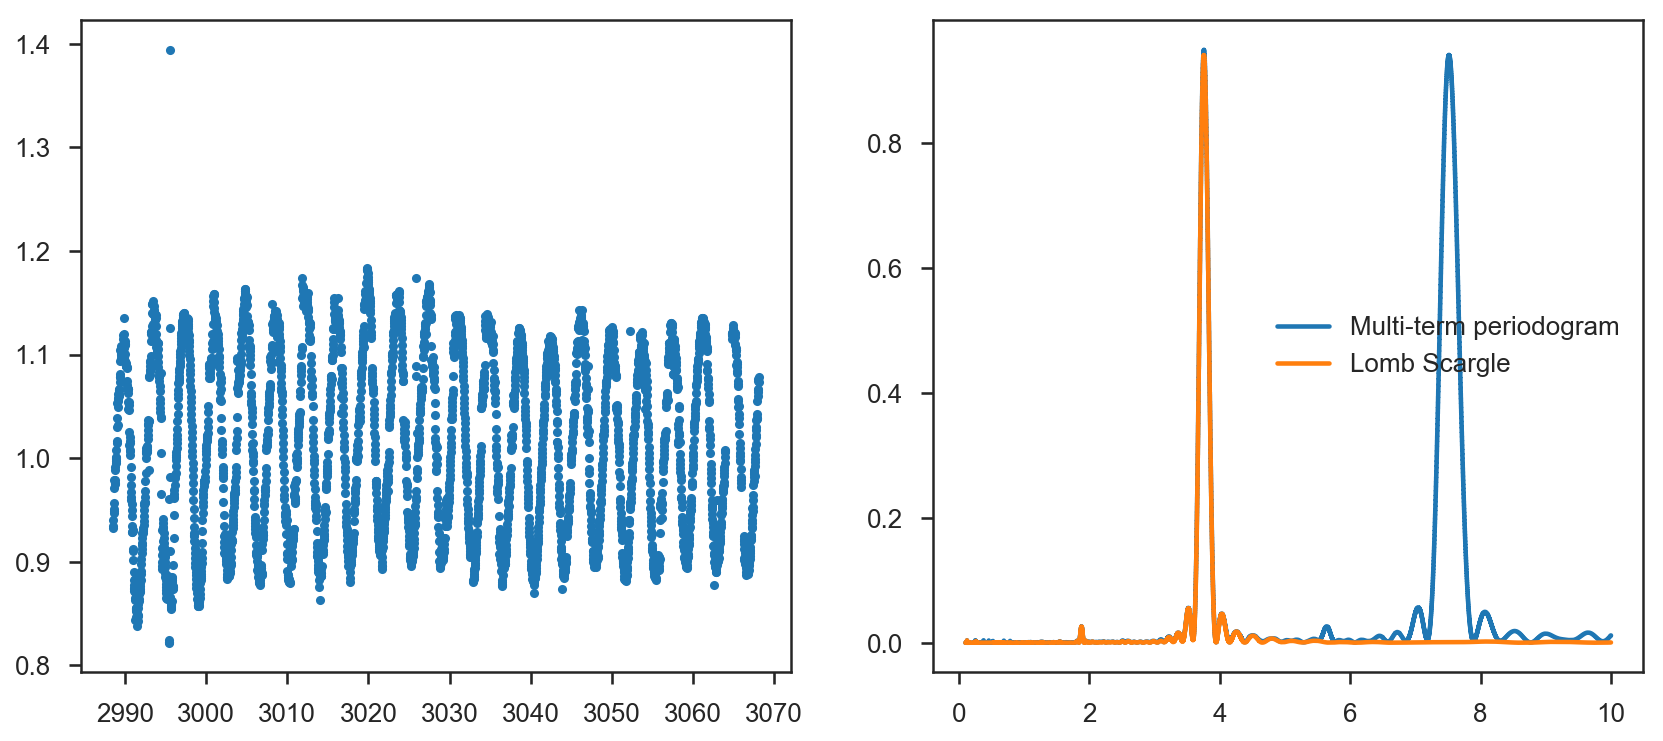

In [81]:
periods, P_M, P_LS = run_periodograms(light_curve)
plot_LC_and_periodograms(light_curve, periods, P_M, P_LS)

In [82]:
p_days_LS, X_sq_M = top_N_periods(periods, P_LS)
p_days_LS

array([3.75841584, 3.52178218, 4.03366337, 1.88118812, 4.25742574])

In [83]:
p_days_M, X_sq_LS = top_N_periods(periods, P_M)
p_days_M

array([3.75841584, 7.51683168, 7.04455446, 3.52178218, 8.06732673])

It looks like $P\sim3.758$ days is the period.

In [84]:
periods_fine, P_M_fine, P_LS_fine = run_periodograms(light_curve, P_range=[3.7, 3.8])

/Users/obsidian/anaconda3/lib/python3.6/site-packages/astroML/time_series/periodogram.py:176: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  M, chi2[i], rank, s = np.linalg.lstsq(X, y)


In [85]:
p_days_M, X_sq_LS = top_N_periods(periods_fine, P_M_fine, n=1)
P_fit = p_days_M[0]

In [86]:
print('The period is {:.4f} days'.format(P_fit))

The period is 3.7586 days


In [92]:
sin_vector = np.sin(2.0*np.pi*x/P_fit)
cos_vector = np.cos(2.0*np.pi*x/P_fit)

A = np.concatenate((np.expand_dims(sin_vector, 1),
                    np.expand_dims(cos_vector, 1),
                    np.vander(x, 3)), axis=1)

ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

yfit = np.matmul(mean_w, A.T)

x_dense = np.arange(x.min(), x.max(), 0.01)

A_dense = np.concatenate((np.expand_dims(np.sin(2.0*np.pi*x_dense/P_fit), 1),
                    np.expand_dims(np.cos(2.0*np.pi*x_dense/P_fit), 1),
                    np.vander(x_dense, 3)), axis=1)

yfit_dense = np.matmul(mean_w, A_dense.T)

In [93]:
y_peak = np.max(yfit)

In [94]:
import seaborn as sns

In [95]:
sns.set_context('talk')

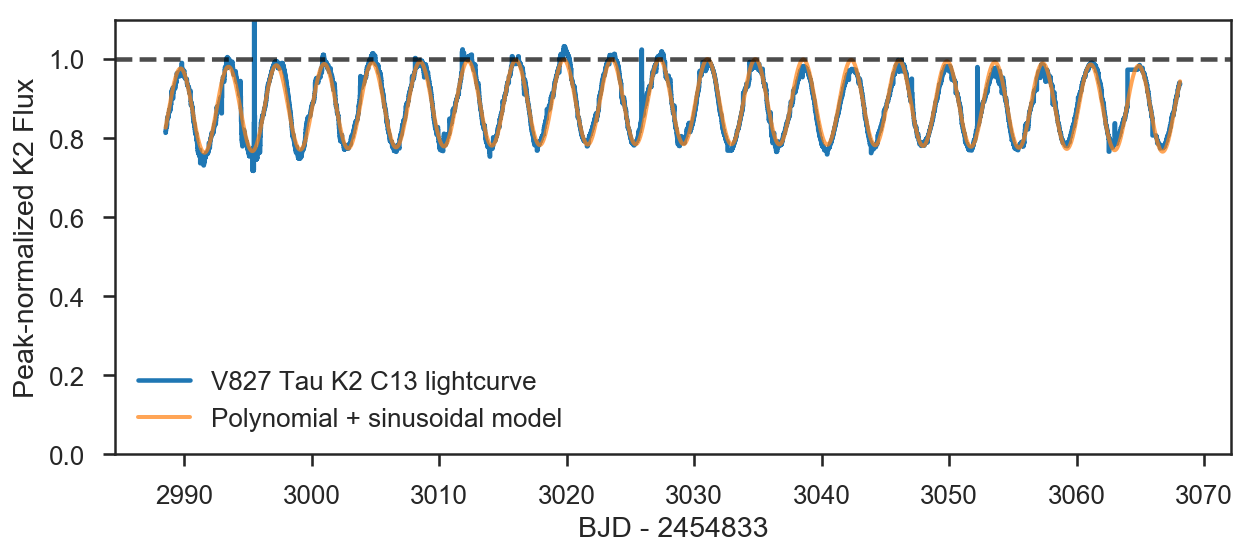

In [108]:
plt.figure(figsize=(10, 4))

plt.step(x, y/y_peak, ms=4, label='V827 Tau K2 C13 lightcurve')
#plt.plot(x, yfit/y_peak, '-', )
plt.plot(x_dense, yfit_dense/y_peak, lw=2, alpha=0.7, label='Polynomial + sinusoidal model')

#plt.xlim(2457200, 2457319+160)
plt.ylim(0, 1.1)
plt.axhline(1, linestyle='dashed', color='k', alpha=0.7)
plt.xlabel('BJD - 2454833')
#plt.title('EPIC 210698281 (V827 Tau) K2 C13 Lightcurve')
plt.ylabel('Peak-normalized K2 Flux')
plt.legend(loc='best')
plt.savefig('../document/figures/V827_Tau_K2C13_lightcurve.pdf', bbox_inches='tight');

In [74]:
omega_best = 2.0*np.pi/P_fit
mtf = astroML.time_series.MultiTermFit(omega_best, 3)

In [75]:
phased = np.mod(light_curve.time.values, P_fit)

In [110]:
ypeak = 1.15
y= y/ypeak

In [111]:
mtf_fit = mtf.fit(phased, y, yerr)
phz, phz_yfit = mtf_fit.predict(100, adjust_offset=False)

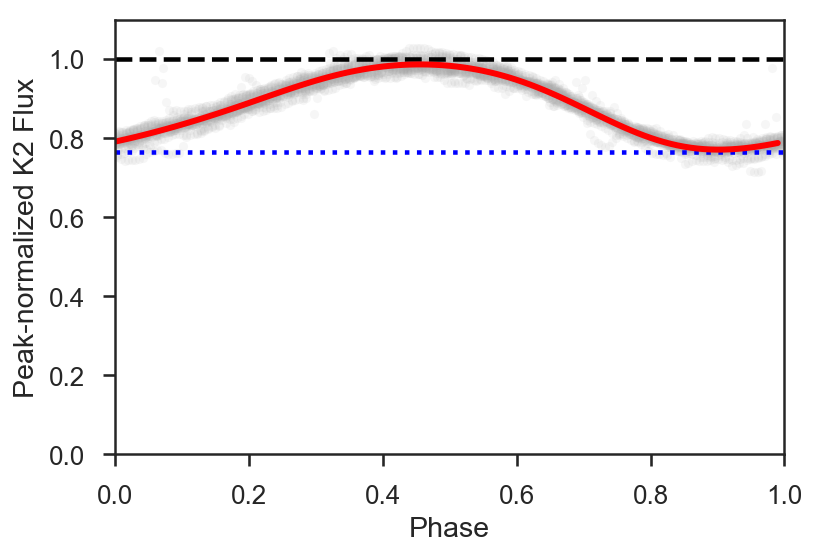

In [114]:
#plt.figure(figsize=(6,6))
    
plt.plot(phased/P_fit+0.0, y, marker='.', linestyle='none', color='#AAAAAA', alpha=0.1)
#plt.plot(phased/P_fit+1.0, y, '.', linestyle='none', color='#AAAAAA', alpha=0.01)
#plt.plot(phased/P_fit-1.0, y, marker='.', linestyle='none', color='#AAAAAA', alpha=0.01)
plt.xlabel('Phase')
plt.ylabel('Peak-normalized K2 Flux')

plt.axhline(1.0, color='k', linestyle='dashed')
plt.axhline(0.765, color='b', linestyle='dotted')

plt.plot(phz, phz_yfit, 'r-', lw=3, alpha=1)

#plt.xlim(-0.25, 1.25)
plt.xlim(0, 1)
plt.ylim(0, 1.1)
#plt.title('V827 Tau: 23.5% minimum starspot coverage')
plt.savefig('../V827_folded.pdf', bbox_inches='tight')

The minimum brightness is typically 76.5% of the peak brightness.

If a *single, large, zero Kelvin* starspot is responsible, it would have to have:


In [38]:
1.0-0.765

0.235

A covering fraction of 23.5%.  Any perturbation to this assumption will only *increase* the coverage fraction.

The end.